In [1]:
from pandana.loaders import osm
import geopandas as gpd
import pydeck as pdk
import ee
import pandas as pd
import contextily as ctx
import plotly.express as px
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandana
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# New York Sate (FIFP=36) county shapfile data
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
nyc_county_data = gpd.read_file(url)
nyc_county_data

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353950,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,1.0,Manhattan,6.365205e+08,357713.308162,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
2,2.0,Bronx,1.187175e+09,463180.579449,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
3,3.0,Brooklyn,1.934138e+09,728146.574928,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4.0,Queens,3.041419e+09,888199.731385,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


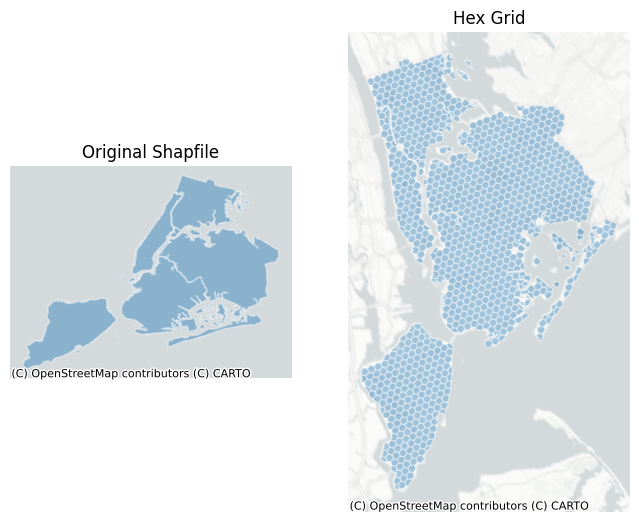

In [3]:
# New York Sate (FIFP=36) county shapfile data
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
nyc_county_data = gpd.read_file(url)
hexes = h3fy(nyc_county_data.to_crs('epsg:4326'), resolution=8, clip=True).to_crs("epsg:26910")


fig, axs = plt.subplots(1,2, figsize=(8,8))
axs=axs.flatten()

nyc_county_data.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Shapfile')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.CartoDB.PositronNoLabels)
    axs[i].axis('off')

C:\Users\Cedric\AppData\Local\Temp\ipykernel_14936\4279904222.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf = ox.geometries_from_place(borough, tags = {'leisure': 'park'})
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a

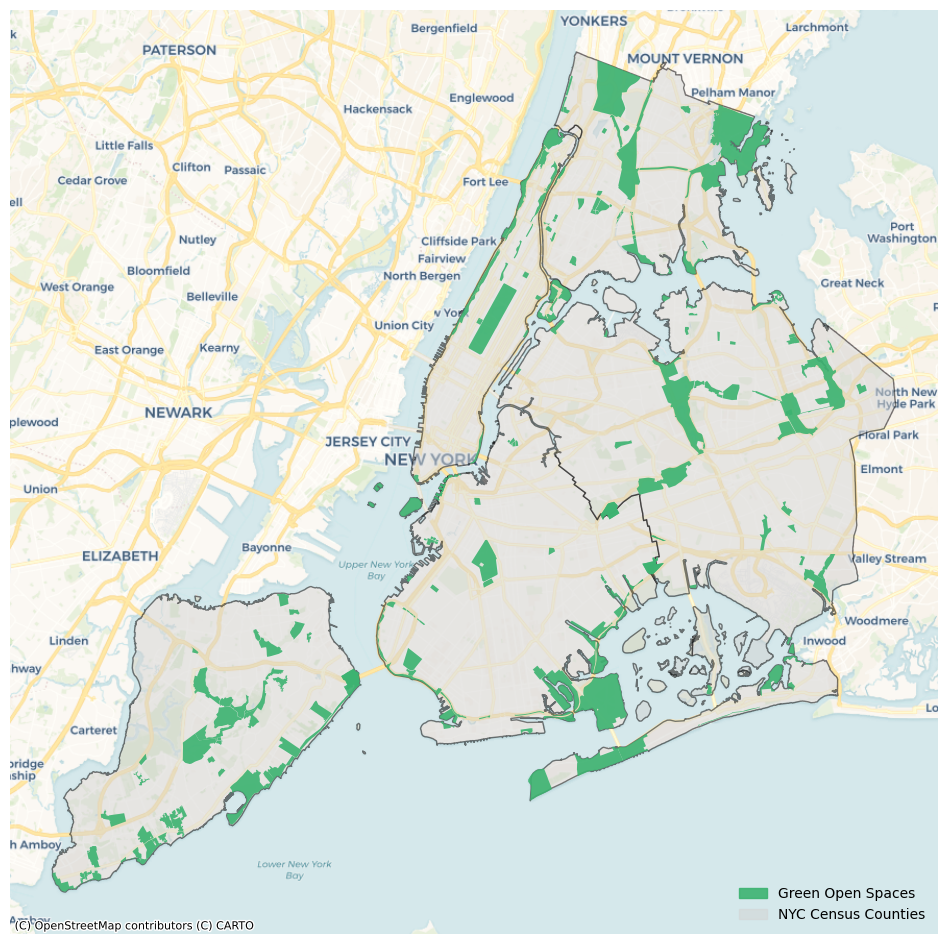

"\ngdf_green_spaces = gdf_green_spaces.to_crs(nyc_county_data.crs)\nfig, ax = plt.subplots(figsize=(10, 10))\nnyc_block_data.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)\ngdf_green_spaces.plot(ax=ax, color='green')\nplt.title('NYC Blocks and Green Spaces')\nplt.show()\n"

In [4]:
# BYC Green Space shapefile
ox.config(use_cache=True, log_console=True)

boroughs = [
    "Manhattan, New York, USA",
    "Brooklyn, New York, USA",
    "Queens, New York, USA",
    "Bronx, New York, USA",
    "Staten Island, New York, USA"
]
gdfs = []
for borough in boroughs:
    gdf = ox.geometries_from_place(borough, tags = {'leisure': 'park'})
    gdf['borough'] = borough.split(',')[0]  # Add a borough name column for reference
    gdfs.append(gdf)
gdf_green_spaces = pd.concat(gdfs, ignore_index=True)

gdf_green_spaces = gdf_green_spaces.to_crs('EPSG:2263')

# Assuming nyc_block_data is also available and needs CRS adjustment
nyc_county_data = nyc_county_data.to_crs('EPSG:2263')

# Calculate the area of each park in square meters
gdf_green_spaces['area'] = gdf_green_spaces.geometry.area

# Filter out smaller parks (e.g., 500,000 square meters)
gdf_green_spaces = gdf_green_spaces[gdf_green_spaces['area'] > 500000]


fig, ax = plt.subplots(figsize=(12, 12))

nyc_county_data.to_crs(epsg=3857).plot(
    ax=ax,
    alpha=0.5,
    edgecolor='black',
    facecolor='lightgrey',
    label='NYC Census Tracts'
)

gdf_green_spaces.to_crs(epsg=3857).plot(
    ax=ax,
    alpha=0.9,
    color='mediumseagreen',
    label='Green Open Spaces',
)

# Add a base map using contextily
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager) # Strava.All Strava.Run Esri.WorldImagery Esri.WorldTopoMap CartoDB.Voyager CartoDB.DarkMatter

# Add legend
green_patch = mpatches.Patch(color='mediumseagreen', alpha=0.9, label='Green Open Spaces')
grey_patch = mpatches.Patch(color='lightgrey', alpha=0.5, label='NYC Census Counties')
ax.legend(handles=[green_patch, grey_patch], loc='lower right', frameon=False)

# Remove axis labels and ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

plt.show()
'''
gdf_green_spaces = gdf_green_spaces.to_crs(nyc_county_data.crs)
fig, ax = plt.subplots(figsize=(10, 10))
nyc_block_data.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)
gdf_green_spaces.plot(ax=ax, color='green')
plt.title('NYC Blocks and Green Spaces')
plt.show()
'''

In [5]:
gdf_green_spaces.geometry.type.unique()

C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


array(['Polygon', 'MultiPolygon'], dtype=object)

In [6]:
gdf_green_spaces = gdf_green_spaces.to_crs(hexes.crs)

C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


In [7]:
# Step 1: Filter for only Polygon and MultiPolygon geometries
gdf_polygons = gdf_green_spaces[gdf_green_spaces.geometry.type.isin(['Point', 'Polygon', 'MultiPolygon'])]

# Step 2: Spatial join to find intersections with hexes
intersections = gpd.sjoin(hexes, gdf_polygons, how="left", op="intersects")

# Step 3: Create a boolean column that marks if there was an intersection
intersections['intersects'] = intersections.index_right.notnull()

# Step 4: Group by hex index and determine if any intersections occurred
intersection_summary = intersections.groupby(intersections.index)['intersects'].any()

# Step 5: Merge this summary back into the original hexes DataFrame
hexes = hexes.merge(intersection_summary.rename('has_green_space'), left_index=True, right_index=True, how='left')

# Step 6: Fill NaN values with False in case some hexes didn't intersect at all
hexes['has_green_space'].fillna(False, inplace=True)

hexes.head()

C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.

,geometry,has_green_space
hex_id,,
882a106e0dfffff,"POLYGON ((4651210.325 5803800.724, 4651011.549...",True
882a106e63fffff,"POLYGON ((4651011.549 5804403.291, 4651210.325...",True
882a106e67fffff,"POLYGON ((4649932.570 5803993.461, 4650131.338...",True
882a106e47fffff,"POLYGON ((4652331.853 5805922.146, 4652530.701...",True
882a106e6bfffff,"POLYGON ((4651252.813 5805512.142, 4651451.652...",True


In [9]:
hexes.to_csv('NYC_Green_Space_HEX.csv')

C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
C:\Users\Cedric\AppData\L

C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
C:\Users\Cedric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geoseries.py:221: DeprecationWarning: Passing a SingleBlockManager to GeoSeries is deprecated and will raise in a future version. Use public APIs instead.
  super().__init__(data, index=index,

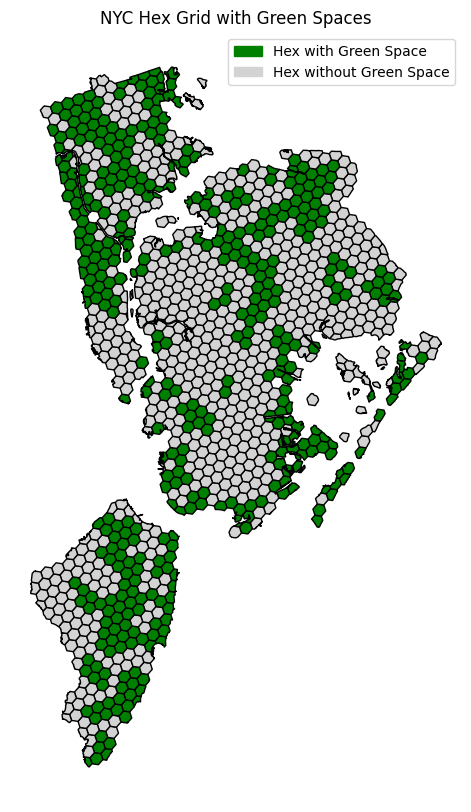

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
hexes.plot(ax=ax, color=hexes['has_green_space'].map({True: 'green', False: 'lightgrey'}), edgecolor='black')

# Create legend handles
green_patch = mpatches.Patch(color='green', label='Hex with Green Space')
grey_patch = mpatches.Patch(color='lightgrey', label='Hex without Green Space')

ax.legend(handles=[green_patch, grey_patch])
ax.set_title('NYC Hex Grid with Green Spaces')
ax.set_axis_off() 
plt.show()